# **Final_Project_Chatbot_Model_by_Kaustubh_Prakash_Deolase**

 =================================================================
# ChatBot_Model_Seq2Seq_Chatbot_(LSTM)_by_Kaustubh_Prakash_Deolase
 =================================================================


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (Embedding, LSTM, Dense, LayerNormalization, Dropout, TextVectorization)
import matplotlib.pyplot as plt

==========================================================
# TEXT CLEANING FUNCTION
==========================================================

In [ ]:
def clean_text(text: str) -> str:
    """Basic text cleaning."""
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r"-", " ", text)
    text = re.sub(r"([?.!,])", r" \1 ", text)
    text = re.sub(r"([0-9])", r" \1 ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

==========================================================
#LOAD AND PREPROCESS DIALOGS
==========================================================

In [ ]:
def load_dialogs(path="dialogs.txt"):
    if not os.path.exists(path):
        raise FileNotFoundError(f"dialogs file not found at: {path}")
    df = pd.read_csv(path, sep="\t", names=["question", "answer"], encoding="utf-8")
    df.dropna(inplace=True)
    df["question"] = df["question"].map(clean_text)
    df["answer"] = df["answer"].map(clean_text)
    return df


==========================================================
#TEXT VECTORIZATION
==========================================================

In [ ]:
def build_vectorizer(texts, max_tokens=5000, seq_len=30):
    vectorizer = TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        output_sequence_length=seq_len,
        standardize=None  # We already cleaned text
    )
    vectorizer.adapt(texts)
    return vectorizer

==========================================================
# ENCODER MODEL
==========================================================

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, units, embedding_dim, vocab_size):
        super().__init__()
        self.embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.norm = LayerNormalization()
        self.dropout = Dropout(0.4)
        self.lstm = LSTM(units, return_sequences=True, return_state=True, dropout=0.4)

    def call(self, x, training=False):
        x = self.embedding(x)
        x = self.norm(x, training=training)
        x = self.dropout(x, training=training)
        outputs, h, c = self.lstm(x, training=training)
        return outputs, h, c

==========================================================
# DECODER MODEL
==========================================================

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, units, embedding_dim, vocab_size):
        super().__init__()
        self.embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.norm1 = LayerNormalization()
        self.lstm = LSTM(units, return_sequences=True, return_state=True, dropout=0.4)
        self.norm2 = LayerNormalization()
        self.dropout = Dropout(0.4)
        self.fc = Dense(vocab_size, activation="softmax")

    def call(self, x, initial_state=None, training=False):
        x = self.embedding(x)
        x = self.norm1(x, training=training)
        x = self.dropout(x, training=training)
        outputs, h, c = self.lstm(x, initial_state=initial_state, training=training)
        outputs = self.norm2(outputs, training=training)
        outputs = self.dropout(outputs, training=training)
        logits = self.fc(outputs)
        return logits, h, c

==========================================================
# BUILD TRAINING MODEL
==========================================================

In [ ]:
def build_training_model(encoder, decoder, seq_len):
    enc_inp = tf.keras.Input(shape=(seq_len,), name="encoder_input")
    dec_inp = tf.keras.Input(shape=(seq_len,), name="decoder_input")
    enc_out, h, c = encoder(enc_inp)
    dec_out, _, _ = decoder(dec_inp, initial_state=[h, c])
    model = tf.keras.Model([enc_inp, dec_inp], dec_out)
    return model

# ==========================================================
#BUILD INFERENCE MODELS (for chatting)
# ==========================================================

In [ ]:
def build_inference_models(encoder, decoder, seq_len, units):
    enc_input = tf.keras.Input(shape=(seq_len,), name="enc_input")
    _, h, c = encoder(enc_input)
    enc_model = tf.keras.Model(enc_input, [h, c])

    dec_input = tf.keras.Input(shape=(1,), name="dec_input")
    h_in = tf.keras.Input(shape=(units,), name="h_in")
    c_in = tf.keras.Input(shape=(units,), name="c_in")
    dec_out, h_out, c_out = decoder(dec_input, initial_state=[h_in, c_in])
    dec_model = tf.keras.Model([dec_input, h_in, c_in], [dec_out, h_out, c_out])
    return enc_model, dec_model

# ==========================================================
#GREEDY DECODING
# ==========================================================

In [ ]:
def greedy_decode(input_text, vectorizer, enc_model, dec_model, id2word, word2id, max_len=20):
    # Convert text to sequence using TextVectorization
    seq = vectorizer([input_text])  # returns tensor (1, seq_len)

    # Encode input sequence to get states
    state_h, state_c = enc_model(seq)

    # Start token id
    start_id = word2id.get('<start>', 1)
    end_id = word2id.get('<end>', 2)

    target_seq = tf.expand_dims([start_id], 0)  # shape (1,1)
    decoded_sentence = []

    for _ in range(max_len):
        output_tokens, h, c = dec_model([target_seq, state_h, state_c])
        sampled_token_index = tf.argmax(output_tokens[0, -1, :]).numpy()
        sampled_word = id2word.get(sampled_token_index, '')

        if sampled_word == '<end>':
            break

        decoded_sentence.append(sampled_word)
        target_seq = tf.expand_dims([sampled_token_index], 0)
        state_h, state_c = h, c

    return ' '.join(decoded_sentence)



# ==========================================================
# MAIN TRAINING PIPELINE
# ==========================================================

In [ ]:
def train_chatbot(data_path="dialogs.txt"):
    # Hyperparameters
    VOCAB_SIZE = 5000
    SEQ_LEN = 30
    EMBED_DIM = 128
    LSTM_UNITS = 256
    EPOCHS = 30
    BATCH_SIZE = 128
    LR = 1e-3

    # Load data
    df = load_dialogs(data_path)
    df["decoder_input"] = "<start> " + df["answer"]
    df["decoder_target"] = df["answer"] + " <end>"

    # Build vocabulary
    combined_text = pd.concat([
        df["question"], df["decoder_input"], df["decoder_target"]
    ])
    vectorizer = build_vectorizer(combined_text, max_tokens=VOCAB_SIZE, seq_len=SEQ_LEN)

    vocab = vectorizer.get_vocabulary()
    word2id = {t: i for i, t in enumerate(vocab)}
    id2word = {i: t for i, t in enumerate(vocab)}

    # Vectorize sequences
    enc_inp = vectorizer(df["question"])
    dec_inp = vectorizer(df["decoder_input"])
    dec_tar = vectorizer(df["decoder_target"])

    # Build model
    encoder = Encoder(LSTM_UNITS, EMBED_DIM, VOCAB_SIZE)
    decoder = Decoder(LSTM_UNITS, EMBED_DIM, VOCAB_SIZE)
    model = build_training_model(encoder, decoder, SEQ_LEN)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    # Train
    ckpt = tf.keras.callbacks.ModelCheckpoint(
        "models/best_seq2seq.keras", monitor="val_loss", save_best_only=True
    )

    history = model.fit(
        [enc_inp, dec_inp], dec_tar,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        callbacks=[ckpt]
    )

    # Save models
    enc_model, dec_model = build_inference_models(encoder, decoder, SEQ_LEN, LSTM_UNITS)
    os.makedirs("models", exist_ok=True)
    model.save("models/seq2seq_model.keras")
    enc_model.save("models/encoder_model.keras")
    dec_model.save("models/decoder_model.keras")

    # Plot metrics
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(history.history["loss"], label="train_loss", color="red")
    ax[0].plot(history.history["val_loss"], label="val_loss", color="blue")
    ax[0].set_title("Loss")
    ax[0].legend()
    ax[1].plot(history.history["accuracy"], label="train_acc", color="green")
    ax[1].plot(history.history["val_accuracy"], label="val_acc", color="orange")
    ax[1].set_title("Accuracy")
    ax[1].legend()
    plt.show()

    print("✅ Training complete and models saved in 'models/' folder.")
    return vectorizer, enc_model, dec_model, id2word, word2id

# ==========================================================
# CHAT LOOP (AFTER TRAINING)
# ==========================================================

In [ ]:
def chat_loop(vectorizer, enc_model, dec_model, id2word, word2id):
    print("\n🤖 Chatbot is ready! Type 'exit' to quit.\n")
    while True:
        msg = input("You: ").strip()
        if msg.lower() in ["exit", "quit", "bye"]:
            print("Chatbot: Goodbye!")
            break
        reply = greedy_decode(clean_text(msg), vectorizer, enc_model, dec_model, id2word, word2id)
        print("Chatbot:", reply)

# ==========================================================
# ENTRY POINT
# ==========================================================

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.0333 - loss: 7.2797 - val_accuracy: 0.0647 - val_loss: 5.5436
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.0682 - loss: 4.9985 - val_accuracy: 0.0711 - val_loss: 5.2919
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.0748 - loss: 4.6992 - val_accuracy: 0.0756 - val_loss: 5.0918
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.0812 - loss: 4.4186 - val_accuracy: 0.0816 - val_loss: 4.9444
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.0879 - loss: 4.1677 - val_accuracy: 0.0853 - val_loss: 4.8625
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.0921 - loss: 4.0025 - val_accuracy: 0.0872 - val_loss: 4.8085
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.0949 - loss: 3.8257 - val_accuracy: 0.0879 - val_loss: 4.7740
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.0976 - loss: 3.7016 - val_accuracy: 0.0887 - v

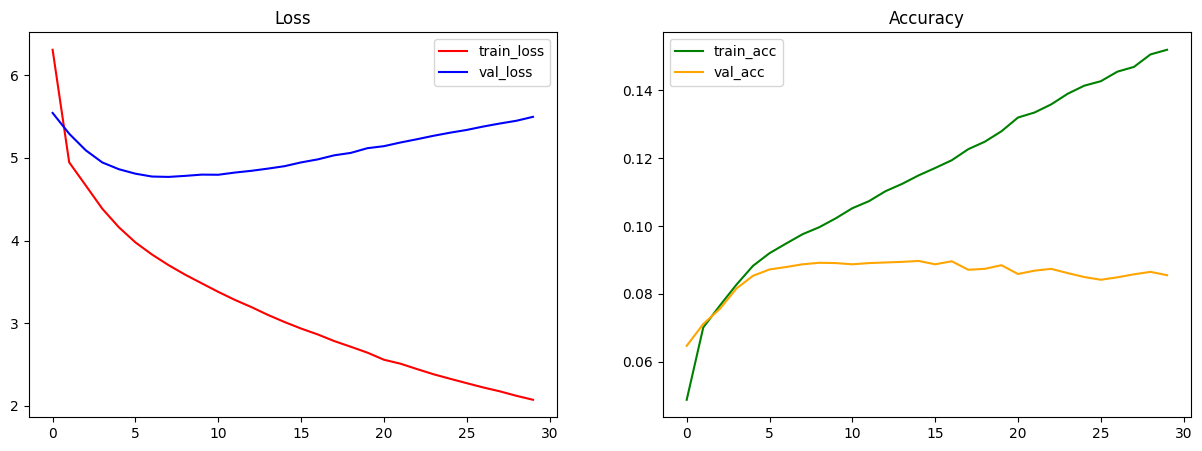

✅ Training complete and models saved in 'models/' folder.


In [ ]:
if __name__ == "__main__":
    vectorizer, enc_model, dec_model, id2word, word2id = train_chatbot("dialogs.txt")
    #chat_loop(vectorizer, enc_model, dec_model, id2word, word2id)

# ==========================================================
# ChatBot Converstion:
# ==========================================================

In [ ]:
# Function to reply to a single user input
def chatbot_reply(user_input, vectorizer, enc_model, dec_model, id2word, word2id):
    user_input = clean_text(user_input)
    return greedy_decode(user_input, vectorizer, enc_model, dec_model, id2word, word2id)

# Function to simulate a conversation from a list of messages
def print_conversation(messages, vectorizer, enc_model, dec_model, id2word, word2id):
    for text in messages:
        print(f'You: {text}')
        reply = chatbot_reply(text, vectorizer, enc_model, dec_model, id2word, word2id)
        print(f'Bot: {reply}')
        print('========================')

# ✅ Example usage
if __name__ == "__main__":
    # Make sure the models are loaded / trained
    # vectorizer, enc_model, dec_model, id2word, word2id = train_chatbot("dialogs.txt")

    test_messages = [
        "hi",
        "how are you?",
        "what is your name?",
        "tell me a joke",
        "bye"
    ]

    print_conversation(test_messages, vectorizer, enc_model, dec_model, id2word, word2id)


You: hi
Bot: i'm not sleeping .
You: how are you?
Bot: i don't know .
You: what is your name?
Bot: i don't know .
You: tell me a joke
Bot: i hope it doesn't rain .
You: bye
Bot: not yet .
